# Sentiment Analysis mit traditionellen Machine Learning Modellen

Im Folgenden nutzen wir traditionelle Modelle (keine ANNs) zur Klassifizierung von Sentiments.  
  
Dafür haben wir mit diversen Machine Learning Algorithmen experimentiert.
Die drei besten Algorithmen betrachten wir genauer:   
- Multinomial Naive Bayes
- Logistische Regression
- Linear Support Vector Machines
  
Desweiteren haben wir die Features auf zwei unterschiedliche Arten erstellt und diese Ansätze ebenfalls miteinander verglichen:
- Bag-of-Words (BoW)
- Term Frequency Inverse Document Frequency (TFIDF)

Sowohl BoW als auch TFIDF haben wir mit verschiedenen N-Grams angewandt, um die Ergebnisse miteinander zu vergleichen.  
Dafür haben wir Unigrams, Bigrams sowie Trigrams verwendet.
  
Dieses Vorgehen haben wir auf zwei unterschiedlichen Datensätzen angewandt:   
- Movie Revies: kleineres Datenset, enthält 3 Klassen (-1: negativ, 0: neutral, 1: positiv)  
- Twetts: größeres Datenset, enthält 2 Klassen (-1: negativ, 1: positiv)  

Abschließend haben wir die Accuracys in Tabellen miteinander verglichen und unsere Ergebnisse ausgewertet und interpretiert.
Beim großen Tweet Datensatz haben wir neben der Accuracy auch die benötigte Zeit für das Training miteinander verglichen, da sich diese stark zwischen den Modellen unterscheidet. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import csv
from evaluation import test_statistics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
%cd Documents/LSC/LSC_Sentiment_Analysis/

[WinError 3] Das System kann den angegebenen Pfad nicht finden: 'Documents/LSC/LSC_Sentiment_Analysis/'
c:\Users\Dell\OneDrive\Desktop\Uni\Semester 2\Ökonometrie\GitHub\LSC_Sentiment_Analysis


## Movie Reviews (kleineres Datenset)
- 8088 Samples (nach Balancing)
- 3 Klassen: -1: negativ, 0: neutral, 1: positiv

## 1. Data Loading

Wir laden den Datensatz, den wir zuvor im Notebook "ExploratoryDataAnalysis" aufbereitet und balanciert haben.


In [3]:
mr_train_set = pd.read_csv ("./data/dataset_mr/Trainset_complete.csv", sep = ';')
mr_test_set = pd.read_csv ("./data/dataset_mr/Testset.csv", sep = ';')

In [4]:
# balancierte Daten
mr_train_set.Sentiment.value_counts()

-1    2696
 0    2696
 1    2696
Name: Sentiment, dtype: int64

## 2. Data Cleaning

Die Daten haben wir zunächst durch folgendes Vorgehen bereinigt:
- alle Zeichen, die keine Buchstaben sind, rausgelöscht. So wird z.B. "amazing" und "amazing." als gleiches Wort gezählt.  
- alle Buchstaben auf Kleinschreibung angepasst. So wird z.B. "Amazing" und "amazing" als gleiches Wort gezählt.
- Stop-Words herausgelöscht. Wir gehen davon aus, dass das Vorhandensein von häufigen Wörtern wie 'and' 'or' 'a' 'she' usw. keinen großen Mehrwert für die Sentimentanalyse liefert. Wir haben die vordefinierten Stop-Words von Natural Language Toolkit (nltk) verwendet, welches 179 Wörter enthält, die sehr häufig in der englischen Sprache vorkommen.
- Stemming: Wortendungen werden abgeschnitten, sodass nur der Wortstamm übrig bleibt. Hierzu verwenden wir den Porter-Stemmer-Algorithmus. Dadurch werden Wörter mit dem gleichen Wortstamm als ein Wort gezählt, z.B. "like" und "likes". 

Anschließend wenden wir die definierten Funktionen sowohl auf unser Trainings- als auch auf unser Testset an.

Durch umfangreiches testen sind wir zu der Erkenntnis gekommen, dass das Data Cleaning die Performance unserer Modelle verbessert. Es können dadurch Wörter, die das gleiche ausdrücken, besser als das gleiche Wort erkannt werden. 
Das Herauslöschen der Stop-Words hat dagegen die Accuracys leicht verschlechtert. Auch in den sehr häufig vorkommenden Wörtern scheint noch ein bisschen Information enthalten zu sein. Daher haben wir im finalen Durchlauf unsere definierte Funktion "remove_stop_words" nicht auf unseren Trainings- und Test-Set angewendet.
Wie Häufig ein Wort vorkommt, berücksichtigen wir später durch die Inverse Document Frequency bei der Erstellung der Features nach dem TFIDF Ansatz (siehe 3. Text Vectorization).  

In [5]:
# Funktion zur Entfernung aller Zeichen außer Buchstaben 
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text

# Funktion zur Anpassung aller Buchstaben auf Kleinschreibung
def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words)

# Funktion zur Entfernung von Stop Words 
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Funktion zur Anwendung von Stemming mit Porter-Stemmer-Algorithmus
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


mr_train_set['Phrase'] = mr_train_set['Phrase'].apply(clean_reviews)
mr_test_set['Phrase'] = mr_test_set['Phrase'].apply(clean_reviews)

# remove_stop_words verschlechtert die Accuracy leicht, daher hier auskommentiert und nicht angewendet
#mr_train_set['Phrase'] = mr_train_set['Phrase'].apply(remove_stop_words)
#mr_test_set['Phrase'] = mr_test_set['Phrase'].apply(remove_stop_words)

mr_train_set['Phrase'] = mr_train_set['Phrase'].apply(text_stemming)
mr_test_set['Phrase'] = mr_test_set['Phrase'].apply(text_stemming)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

## 3. Text Vectorization
In diesem Schritt wandeln wir unsere Daten in numerische Form um und erstellen so unsere Features.  
Dabei werden die Reviews in eine Matrix aus token counts umgewandelt.  
Der Vektorizer wird dabei an die Trainingsdaten angepasst. Die Anzahl der Features entspricht somit der Anzahl der Token, die im Trainings-Set enthalten sind.  
Dieses Vokabular verwenden wir anschließend ebenfalls zur Transformation des Test-Sets.  
Token, die nur im Test-Set auftauchen, werden von dem Modell also nicht berücksichtigt. Die Test-Daten sollen zunächst für das Modell verborgen bleiben.   
Zudem kann ein Token, das nicht in den Trainingsdaten enthalten ist, nicht gelernt werden und liefert somit keinen Mehrwert für die Vorhersage.   

Wir erstellen die Features auf zwei verschiedene Arten um sie nachher bzgl. ihrer Accuracy zu vergleichen:  
- Bag-of-Words (BoW) -> Dafür nutzen wir den CountVectorizer mit dem Parameter binary=False, sodass die Häufigkeit der Token berücksichtigt wird und nicht nur das Vorhandensein (1:ja, 0:nein)  
- Term Frequency Inverse Document Frequency (TFIDF) -> Dafür nutzen wir den TfidfVectorizer mit dem Parameter use_idf=True, sodass neben der Term Frequency auch die Inverse Document Frequency berücksichtigt wird


Begriffsklärung:  
Term Frequency: Beim BoW Ansatz werden ausschließlich das Vokabluar von Wörtern, sowie die Häufigkeit eines Wortes pro Dokument (hier: Review) berücksichtigt.  

Bei der Bestimmung von TFIDF Features berücksichtigen wir neben der Term Frequency zusätzlich die Inverse Document Frequency.  
Diese untersucht das Vorhandensein eines Tokens in allen Dokumenten.  
Ein Token, das in wenigen Dokumenten vorkommt, bekommt einen höheren IDF-Wert.  
Ein Token, das in den meisten Dokumenten vorkommt, erhält dagegen einen geringeren IDF-Wert.  
So können seltene Wörter stärker und häufige Wörter schwächer gewichtet werden.    
Der TF-IDF errechnet sich anschließend als Produkt aus der Term Frequency und der Inverse Document Frequency.


### N-Grams
Mit N-Grams können wir vorgeben, ob der Bag-of-Words bzw. TGIDF Algorithmus nur einzelne Wörter oder auch aufeinanderfolgende Wörter berücksichtigt
- Unigram: Alle eindeutigen Wörter in einem Dokument
- BiGram: Alle Permutationen von zwei aufeinanderfolgenden Wörtern in einem Dokument
- TriGram: Alle Permutationen von drei aufeinanderfolgenden Wörtern in einem Dokument

Nach Vectorization:  
Jeder Token im Vokabular wird durch eine Spalte im Datensatz repräsentiert.
Für jedes Review im Datensatz wird die Frequency der Token (term-frequency) dargestellt.

In [6]:
# Text Daten in numerische Daten umwandeln

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

# Vectorizer für Bag-of-Word
# Unigram
mr_vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
mr_vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
mr_vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))

In [7]:
# Vectorizer für TGIDF
# Unigram
mr_vectorizer_uni_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
mr_vectorizer_bi_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
mr_vectorizer_tri_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [8]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - BoW

mr_uni_train_bow = mr_vectorizer_uni_bow.fit_transform(mr_train_set['Phrase'])
mr_uni_test_bow = mr_vectorizer_uni_bow.transform(mr_test_set['Phrase'])

mr_bi_train_bow = mr_vectorizer_bi_bow.fit_transform(mr_train_set['Phrase'])
mr_bi_test_bow = mr_vectorizer_bi_bow.transform(mr_test_set['Phrase'])

mr_tri_train_bow = mr_vectorizer_tri_bow.fit_transform(mr_train_set['Phrase'])
mr_tri_test_bow = mr_vectorizer_tri_bow.transform(mr_test_set['Phrase'])

In [9]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TGIDF

mr_uni_train_tfidf = mr_vectorizer_uni_tfidf.fit_transform(mr_train_set['Phrase'])
mr_uni_test_tfidf = mr_vectorizer_uni_tfidf.transform(mr_test_set['Phrase'])

mr_bi_train_tfidf = mr_vectorizer_bi_tfidf.fit_transform(mr_train_set['Phrase'])
mr_bi_test_tfidf = mr_vectorizer_bi_tfidf.transform(mr_test_set['Phrase'])

mr_tri_train_tfidf = mr_vectorizer_tri_tfidf.fit_transform(mr_train_set['Phrase'])
mr_tri_test_tfidf = mr_vectorizer_tri_tfidf.transform(mr_test_set['Phrase'])

In [10]:
mr_train_labels = mr_train_set['Sentiment']
mr_test_labels = mr_test_set['Sentiment']

## 4. Klassifikationsmodelle trainieren

Zunächst trainieren wir diverse Klassifikations-Algorithmen, die wir anhand ihrer Accuracy miteinander vergleichen.  
Im ersten Schritt trainieren wir nur mit den Unigram Bag-of-Words Features, um einen ersten Eindruck zu bekommen, welche Modelle sich am besten für unsere Sentiment Analyse eignen.  
Die folgenden drei Modelle erreichen dabei die beste Accuracy:

- Naive Bayes  
- Logistische Regression  
- Linear Support Vector Machines (LSVM)

Diese wollen wir im weiteren Verlauf genauer betrachten.
Dafür geben wir nacheinander die Unigrams, Bigrams und Trigrams in die Modelle, sodass wir die Accuracy vergleichen können.  
Dieses Vorgehen machen wir erst mit den BoW Features und anschließend mit TFIDF Features. Am Ende vergleichen wir alle Accuracys miteinander, um den besten Ansatz zu finden.  
  
Unsere Ergebnisse haben wir uns als Confusion Matrix und als Classification-Report ausgeben lassen.  
In der Confusion Matrix werden die vorhergesagten Klassen und die tatsächlichen Klassen auf jeweils einer Achse gegenübergestellt. 
Dadurch lässt sich gut erkennen, welche tatsächlichen Klassen wie vorhergesagt wurden.  
  
Im Classification Report werden diverse Scores ausgegeben (Erklärung am Beispiel der positiven Klasse):
- Precision: Wie viel der positiven Vorhersagen waren richtig, also auch tatsächlich positive Reviews
- Recall (Sensitivity): Wie viele der tatsächlich positiven Fälle wurden erfasst 
- F1: Harmonisches Mittel aus Precision und Recall
- Support: Wie viele Samples sind in der jeweiligen Klasse im Test-Set vorhanden

Diese Scores werden für jede Klasse der drei Klassen ausgegeben. Sollten die Daten im Test-Set stark unbalanciert sein, ist die Accuracy (der Anteil der richtig erkannten Labels) ggf. kein guter Performance-Indikator. Kommt eine Klasse beispielsweise nur zu 1% vor und die andere Klasse zu 99%, kann ein Modell trotz einer Accuracy von 99% unbrauchbar sein.  
In diesem Fall kann die Performance des Modells anhand des Recall-Scores der seltenen Klasse besser bewertet werden als mit der Accuracy.

Precision, Recall und F1-Score werden zudem als macro Average sowie weighted Average ausgegeben. 
- Macro Average: alle Klassen tragen gleichermaßen zum endgültigen Durchschnittswert bei
- Weighted Average: der Beitrag jeder Klasse zum Durchschnitt wird nach ihrer Größe gewichtet  

Da unsere Daten balanciert sind, ist der Ausgabewert für macro average und weighted average gleich. 

### 4.1. Vergleich diverser Modelle

Vergleich diverser klassischer Klassifikationsalgorithmen:
- Logistische Regression
- K-Nearest-Neighbors
- Random Forest
- Linear Support Vector Machines
- Nearest Centroid
- Mutinomial Naive Bayes

In [11]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(mr_tri_train_tfidf, mr_train_labels)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(mr_tri_test_tfidf)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(mr_test_labels, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [12]:
# diverse Modelle testen, die 3 mit bester Accuracy verfolgen wir weiter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    (NearestCentroid(), "NearestCentroid"),
    (MultinomialNB(), "Multinomial naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 9.32s
test time:  0.00897s
accuracy:   0.525
dimensionality: 149429
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.00504s
test time:  2.54s
accuracy:   0.478

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.86e+02s
test time:  0.161s
accuracy:   0.471

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time: 0.458s
test time:  0.001s
accuracy:   0.53
dimensionality: 149429
density: 1.0


NearestCentroid
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.013s
t

### 4.2.  Naive Bayes

Der Naive Bayes Klassifizierer sagt das Label einer neuen Beobachtung voraus, indem er die Wahrscheinlichkeiten für alle möglichen Zustände dieser Variablen berechnet und den Zustand mit der höchsten Wahrscheinlichkeit vorhersagt. In diesem Fall gibt es drei mögliche Zustände: positive, neutrale oder negative Bewertung.  
  
Zunächst wird für die drei Zustände der Prior berechnet: Die Wahrscheinlichkeit für das Auftreten des Zustandes an sich  
-> z.B. die Wahrscheinlichkeit, dass es sich um einen negativen Review handelt.   
Da wir mit balancierten Daten arbeiten, ist der Prior für jede der drei Klassen: 0,33333
  
Anschließend werden die bedingten Wahrscheinlichkeiten (Conditional Likelihoods) berechnet:  
Wahrscheinlichkeit, dass Wort n vorkommt, unter der Bedingung, dass es z.B. eine positive Bewertung ist.  
Die Conditional Likelihoods für jedes Wort in der Bewertung werden miteinander sowie mit dem jeweiligen Prior der Klasse multipliziert.  
Diese Berechnung wird für jede mögliche Klasse durchgeführt.  
Anschließend wird die Klasse mit der höchsten Wahrscheinlichkeit angenommen.  

Beim MultinomialNB von sklearn kann über den Parameter "fit_prior" angegeben werden, ob der Prior einer Klasse für die Berechnung einbezogen werden soll.
Sein default-Wert ist true. Da wir mit balancierten Daten arbeiten, macht es in unserem Fall keinen Unterschied, ob wir diesen Parameter auf TRUE oder FALSE setzen.  
Des Weiteren ist es möglich über den Parameter "class_prior" die Priors für die Klassen vorzugeben und dadurch die Wahrscheinlichkeiten zu beeinflussen.
Wir haben mit diversen Einstellungen dieses Parameters experimentiert. Wenn wir den Prior für "neutral" auf 0.5 hochsetzen und die Prior für "negativ" und "positiv" auf 2.5, dann kann der Algorithmus neutrale Reviews deutlich besser erkennen.  
Dafür werden die Predictions der tatsächlich positiven oder tatsächlich negativen Reviews schlechter, sodass die Accuracy gleich bleibt.  

Vorteile:
- Naive Bayes benötigt keine kontinuierlichen Werte, wir könnten auch mit den Labels "negativ", "neutral", "positiv" trainieren  
(da wir das Preprocessing einheitlich für alle Modelle vorgenommen haben, arbeiten wir mit kontinuierlichen Werten)
- Algorithmus ist sehr einfach und schnell zu trainieren
  
Nachteile:
- Nur Labels funktionieren als Input, was für uns aber kein Problem darstellt, da wir ohnehin Labels als Input haben
- Naive Annahme:  
Dem Naive Bayes Klassifizierer liegt die Annahme zugrunde, dass es keine Abhängigkeiten zwischen den Features gibt.  
Diese Annahme wird in der Praxis fast immer verletzt, so wie auch in diesem Fall. Bestimmte Wörter werden häufiger zusammen benutzt.  
Kommt zum Beispiel das Word "lustig" in einem Satz vor, ist es wahrscheinlicher, dass auch das Wort "lachen" darin vorkommt.  
  
Trotzdem liefert der Naive Bayes Klassifizierer interessante Informationen.

#### 4.2.1. Naive Bayes: Unigram
Wir wenden den Naive Bayes Klassifierer auf unsere bereits definierten Unigram Features an

##### 4.2.1.1 Bag-of-Words

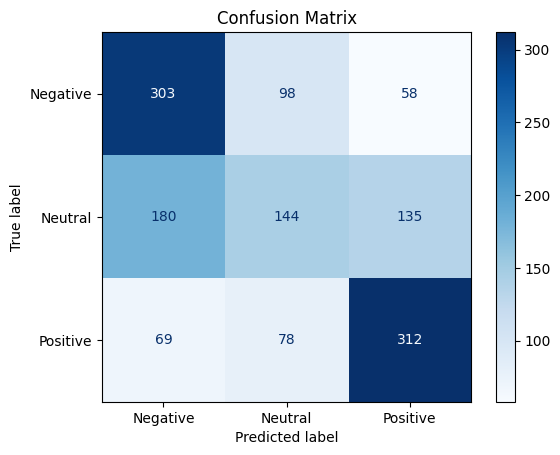

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.66      0.60       459
     Neutral       0.45      0.31      0.37       459
    Positive       0.62      0.68      0.65       459

    accuracy                           0.55      1377
   macro avg       0.54      0.55      0.54      1377
weighted avg       0.54      0.55      0.54      1377



In [13]:
uni_nb = MultinomialNB()
uni_nb.fit(mr_uni_train_bow, mr_train_labels)

predictions = uni_nb.predict(mr_uni_test_bow)

mr_nb_uni_bow = test_statistics(predictions, mr_test_labels)

##### 4.2.1.1 Bag-of-Words mit Parameter class_prior um neutrale Reviews besser zu erkennen
Durch den Parameter "class_prior" können wir den Prior für die Klassen vorgeben.
Dadurch können wir das Problem angehen, dass neutrale Reviews schlecht erkannt werden, indem wir die Prior-Wahrscheinlichkeit für die Klasse "neutral" höher angeben als den Prior für die anderen beiden Klasse "negativ" und "positiv".

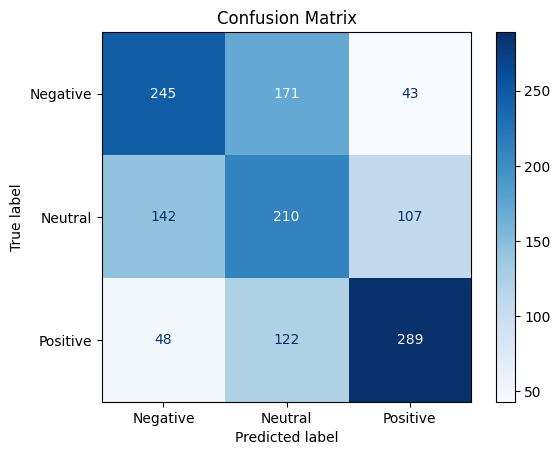

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.53      0.55       459
     Neutral       0.42      0.46      0.44       459
    Positive       0.66      0.63      0.64       459

    accuracy                           0.54      1377
   macro avg       0.55      0.54      0.54      1377
weighted avg       0.55      0.54      0.54      1377



0.5403050108932462

In [14]:
uni_nb = MultinomialNB(class_prior = [0.25, 0.5, 0.25])
uni_nb.fit(mr_uni_train_bow, mr_train_labels)

predictions = uni_nb.predict(mr_uni_test_bow)
test_statistics(predictions, mr_test_labels)

##### 4.2.1.2 TFIDF

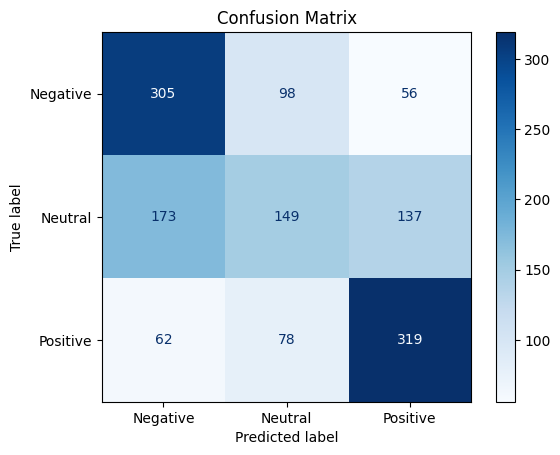

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.66      0.61       459
     Neutral       0.46      0.32      0.38       459
    Positive       0.62      0.69      0.66       459

    accuracy                           0.56      1377
   macro avg       0.55      0.56      0.55      1377
weighted avg       0.55      0.56      0.55      1377



In [15]:
uni_nb = MultinomialNB()
uni_nb.fit(mr_uni_train_tfidf, mr_train_labels)

predictions = uni_nb.predict(mr_uni_test_tfidf)

mr_nb_uni_tf = test_statistics(predictions, mr_test_labels)

#### 4.2.2 Naive Bayes: Bigram

##### 4.2.2.1 Bag-of-Words

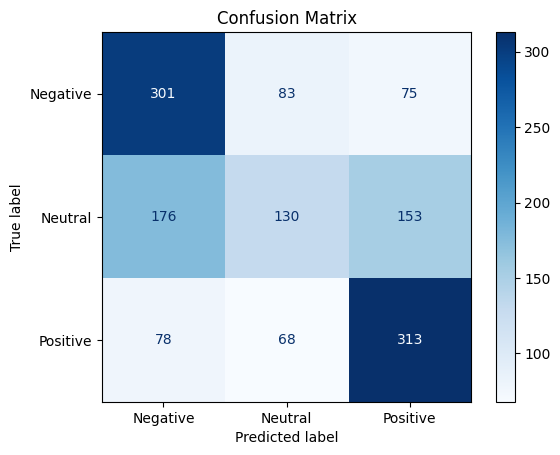

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.66      0.59       459
     Neutral       0.46      0.28      0.35       459
    Positive       0.58      0.68      0.63       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.52      1377
weighted avg       0.53      0.54      0.52      1377



In [16]:
bi_nb = MultinomialNB()
bi_nb.fit(mr_bi_train_bow, mr_train_labels)

predictions = bi_nb.predict(mr_bi_test_bow)
mr_nb_bi_bow = test_statistics(predictions, mr_test_labels)


##### 4.2.2.2 TFIDF

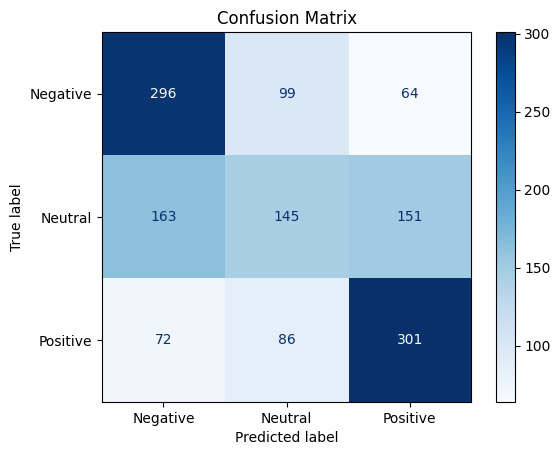

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.64      0.60       459
     Neutral       0.44      0.32      0.37       459
    Positive       0.58      0.66      0.62       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.53      1377
weighted avg       0.53      0.54      0.53      1377



In [17]:
bi_nb = MultinomialNB()
bi_nb.fit(mr_bi_train_tfidf, mr_train_labels)

predictions = bi_nb.predict(mr_bi_test_tfidf)
mr_nb_bi_tf = test_statistics(predictions, mr_test_labels)

#### 4.2.3 Naive Bayes: Trigram

##### 4.2.3.1 Bag-of-Words

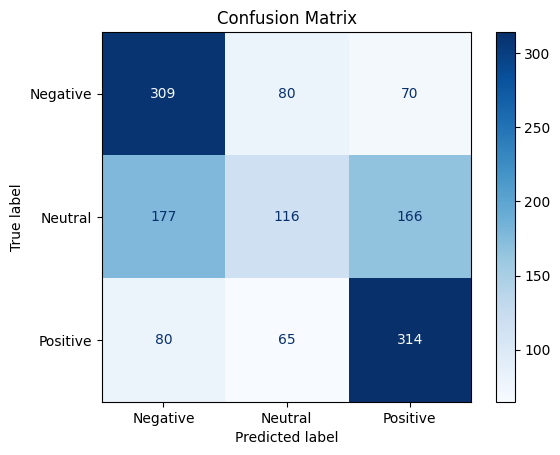

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.67      0.60       459
     Neutral       0.44      0.25      0.32       459
    Positive       0.57      0.68      0.62       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [18]:
tri_nb = MultinomialNB()
tri_nb.fit(mr_tri_train_bow, mr_train_labels)

predictions = tri_nb.predict(mr_tri_test_bow)
mr_nb_tri_bow = test_statistics(predictions, mr_test_labels)


##### 4.2.3.2 TFIDF

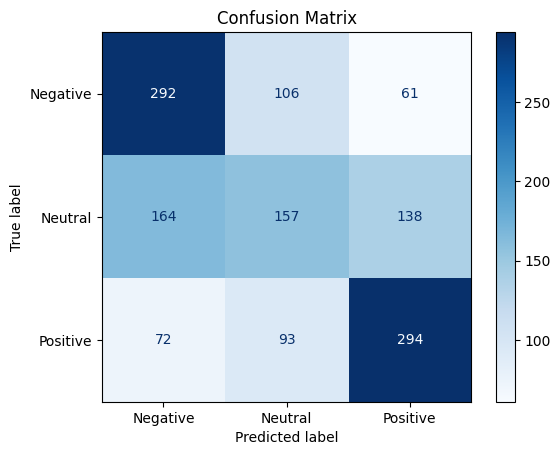

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.64      0.59       459
     Neutral       0.44      0.34      0.39       459
    Positive       0.60      0.64      0.62       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.53      1377
weighted avg       0.53      0.54      0.53      1377



In [19]:
tri_nb = MultinomialNB()
tri_nb.fit(mr_tri_train_tfidf, mr_train_labels)

predictions = tri_nb.predict(mr_tri_test_tfidf)
mr_nb_tri_tf = test_statistics(predictions, mr_test_labels)

### 4.3 Logistische Regression



#### 4.3.1. Log Regression: Unigram

##### 4.3.1.1 Bag-of-Words

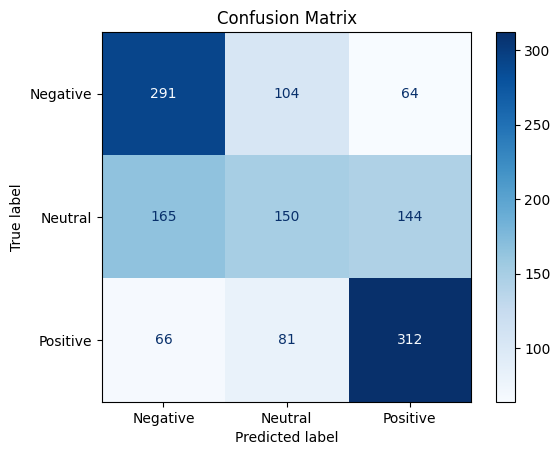

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.63      0.59       459
     Neutral       0.45      0.33      0.38       459
    Positive       0.60      0.68      0.64       459

    accuracy                           0.55      1377
   macro avg       0.54      0.55      0.54      1377
weighted avg       0.54      0.55      0.54      1377



In [20]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(mr_uni_train_bow, mr_train_labels)

predictions = uni_logreg.predict(mr_uni_test_bow)
mr_lr_uni_bow = test_statistics(predictions, mr_test_labels)

##### 4.3.1.2 TFIDF

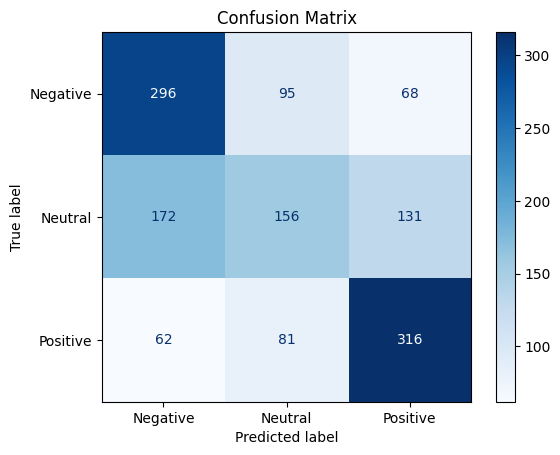

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.64      0.60       459
     Neutral       0.47      0.34      0.39       459
    Positive       0.61      0.69      0.65       459

    accuracy                           0.56      1377
   macro avg       0.55      0.56      0.55      1377
weighted avg       0.55      0.56      0.55      1377



In [21]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(mr_uni_train_tfidf, mr_train_labels)

predictions = uni_logreg.predict(mr_uni_test_tfidf)
mr_lr_uni_tf = test_statistics(predictions, mr_test_labels)

#### 4.3.2. Log Regression: Bigram

##### 4.3.2.1 Bag-of-Words

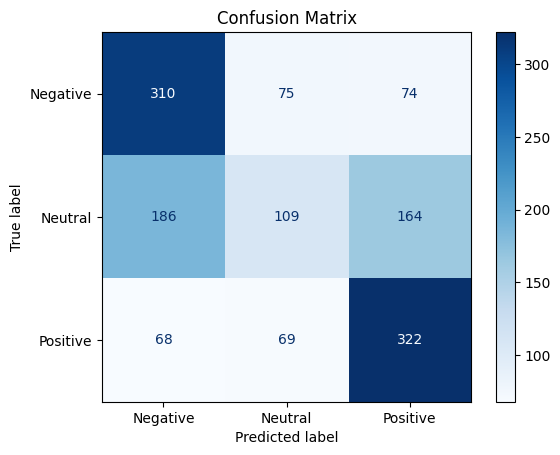

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.68      0.61       459
     Neutral       0.43      0.24      0.31       459
    Positive       0.57      0.70      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.51      1377
weighted avg       0.52      0.54      0.51      1377



In [22]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(mr_bi_train_bow, mr_train_labels)

predictions = bi_logreg.predict(mr_bi_test_bow)
mr_lr_bi_bow = test_statistics(predictions, mr_test_labels)
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt

##### 4.3.2.2 TFIDF

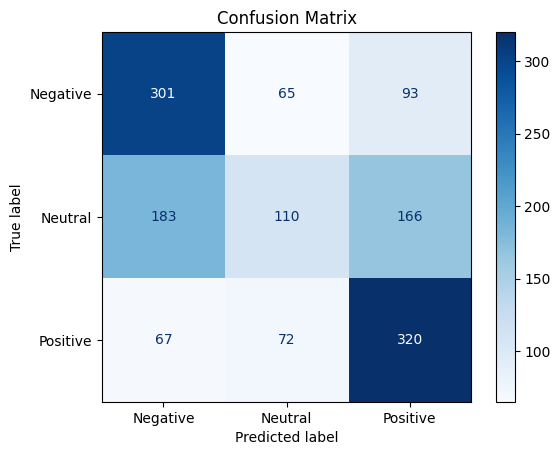

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.66      0.60       459
     Neutral       0.45      0.24      0.31       459
    Positive       0.55      0.70      0.62       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [23]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(mr_bi_train_tfidf, mr_train_labels)

predictions = bi_logreg.predict(mr_bi_test_tfidf)
mr_lr_bi_tf = test_statistics(predictions, mr_test_labels)

#### 4.3.3. Log Regression: Trigram

##### 4.3.3.1 Bag-of-Words

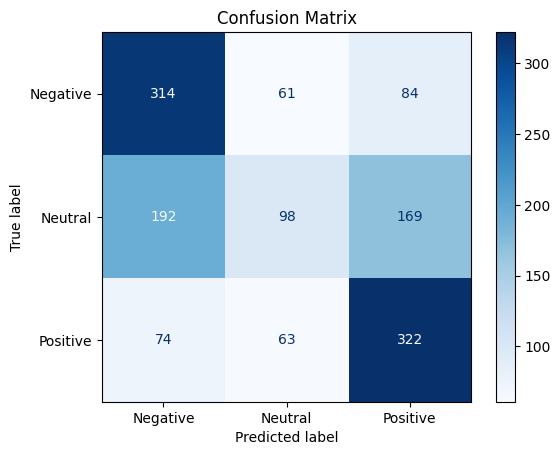

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.68      0.60       459
     Neutral       0.44      0.21      0.29       459
    Positive       0.56      0.70      0.62       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [24]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(mr_tri_train_bow, mr_train_labels)

predictions = tri_logreg.predict(mr_tri_test_bow)
mr_lr_tri_bow = test_statistics(predictions, mr_test_labels)

##### 4.3.3.2 TFIDF

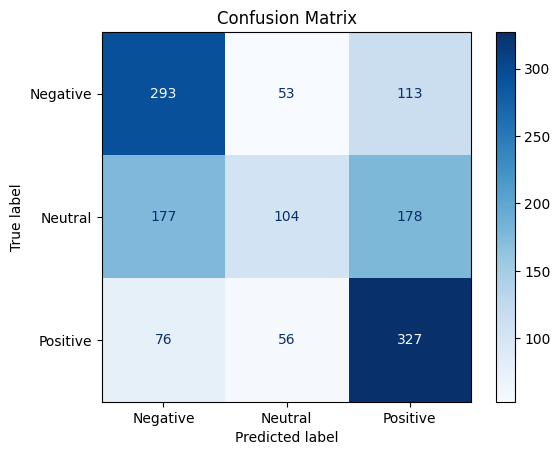

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.64      0.58       459
     Neutral       0.49      0.23      0.31       459
    Positive       0.53      0.71      0.61       459

    accuracy                           0.53      1377
   macro avg       0.52      0.53      0.50      1377
weighted avg       0.52      0.53      0.50      1377



In [25]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(mr_tri_train_tfidf, mr_train_labels)

predictions = tri_logreg.predict(mr_tri_test_tfidf)
mr_lr_tri_tf = test_statistics(predictions, mr_test_labels)

### 4.4 Linear Support Vector Machine (LSVM)

Support Vektor Maschinen teilen die Klassen mithilte von Trennungsebenen ein. Dabei werden die Ebenen so gewählt, dass zwischen den Klassen ein möglichst großer Bereich bleibt, der frei von Samples ist.  

Wir haben uns für den LinearSVC Klassifizierer entschieden, da dieser deutlich weniger Zeit benötigt, als der SVC Klassifizierer und dabei ähnlich gute Ergebnisse liefert.
Die besten Ergebnisse haben wir mit den Parametereinstellungen squared_hinge als Loss-Funktion in Kombination mit der L2-Regularisierung (auch Ridge-Regression) erreicht.
Bei der L2 Regularisierung wird ein Bestrafungswert (=Penalty) auf die Loss-Funktion gerechnet, wenn Gewichte verwendet werden. Dies führt dazu, dass Gewichte nur voll einbezogen werden, wenn ihr Beitrag zur Verringerung des Loss höher ist, als der Bestrafungswert. Im Gegensatz zur L1-Regularisierung (Lasso Regression), nähern sich die Gewichte bei der L2-Regularisierung nur an 0 an, gehen aber nicht gegen 0. Die bessere Performance der L2-Regularisierung im Vergleich zur L1-Regularisierung spricht dafür, dass der Großteil unserer Token wertvolle Prädiktoren sind, die zur Veringerung des Loss beitragen.
Das kann damit zusammenhängen, dass wir zuvor die Stop-Words, die wenig Mehrwert für die Sentimentanalyte liefern, herausgelöscht haben.

Für uns relevante Vorteile bestehen in dem einfachen Training des Modells. Zudem skalieren SVM gut für höherdimensionale Daten.
Ein Nachteil, der für uns problematisch werden kann, ist die Tatsache, dass SVM mehr Samples als Anzahl an Features benötigen um gut zu funktionieren. Dies ist beim Bag-of-Word Ansatz selten der Fall, da jedes Wort (Unigram) bzw. die Kobination von Wörtern (Bi- und Trigrams) ein Feature darstellt und wir somit mehr Features als Samples (also Bewertungen) haben.  

#### 4.4.1. LSVM: Unigram

##### 4.4.1.1 Bag-of-Words

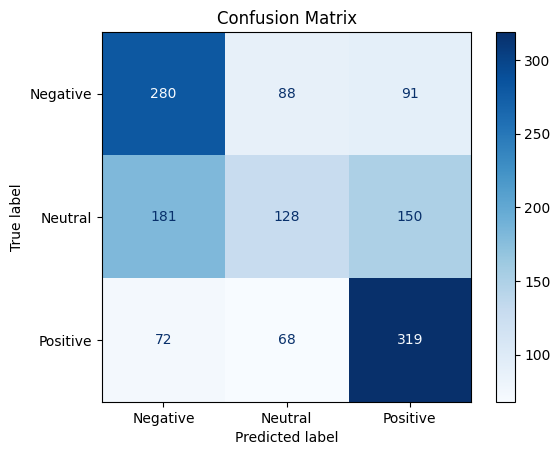

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.61      0.56       459
     Neutral       0.45      0.28      0.34       459
    Positive       0.57      0.69      0.63       459

    accuracy                           0.53      1377
   macro avg       0.52      0.53      0.51      1377
weighted avg       0.52      0.53      0.51      1377



In [26]:
uni_lsvm = sklearn.svm.LinearSVC(loss = 'squared_hinge', penalty='l2')
uni_lsvm.fit(mr_uni_train_bow, mr_train_labels)

predictions = uni_lsvm.predict(mr_uni_test_bow)
mr_ls_uni_bow = test_statistics(predictions, mr_test_labels)

##### 4.4.1.2 TFIDF

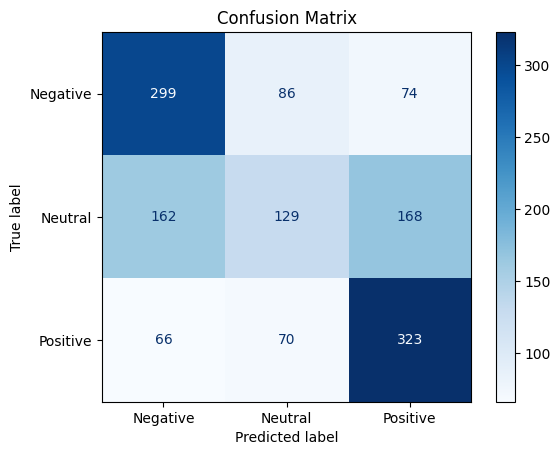

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.57      0.65      0.61       459
     Neutral       0.45      0.28      0.35       459
    Positive       0.57      0.70      0.63       459

    accuracy                           0.55      1377
   macro avg       0.53      0.55      0.53      1377
weighted avg       0.53      0.55      0.53      1377



In [27]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(mr_uni_train_tfidf, mr_train_labels)

predictions = uni_lsvm.predict(mr_uni_test_tfidf)
mr_ls_uni_tf = test_statistics(predictions, mr_test_labels)

#### 4.4.2. LSVM: Bigram

##### 4.4.2.1 Bag-of-Words

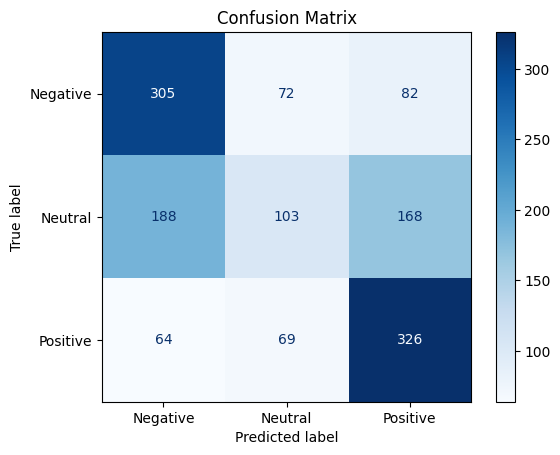

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.66      0.60       459
     Neutral       0.42      0.22      0.29       459
    Positive       0.57      0.71      0.63       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [28]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(mr_bi_train_bow, mr_train_labels)

predictions = bi_lsvm.predict(mr_bi_test_bow)
mr_ls_bi_bow = test_statistics(predictions, mr_test_labels)

##### 4.4.2.2 TFIDF

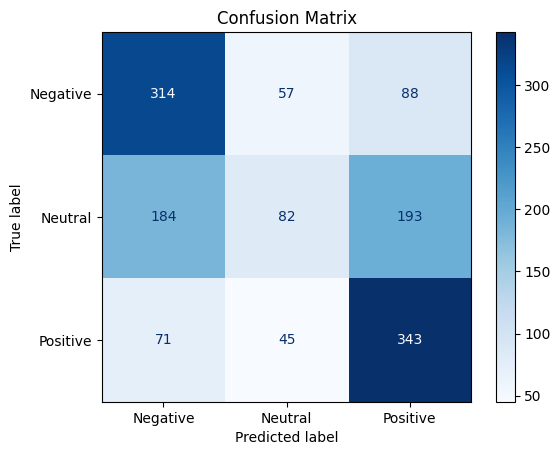

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.68      0.61       459
     Neutral       0.45      0.18      0.26       459
    Positive       0.55      0.75      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.50      1377
weighted avg       0.52      0.54      0.50      1377



In [29]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(mr_bi_train_tfidf, mr_train_labels)

predictions = bi_lsvm.predict(mr_bi_test_tfidf)
mr_ls_bi_tf = test_statistics(predictions, mr_test_labels)

#### 4.4.3. LSVM: Trigram

##### 4.4.3.1 Bag-of-Words

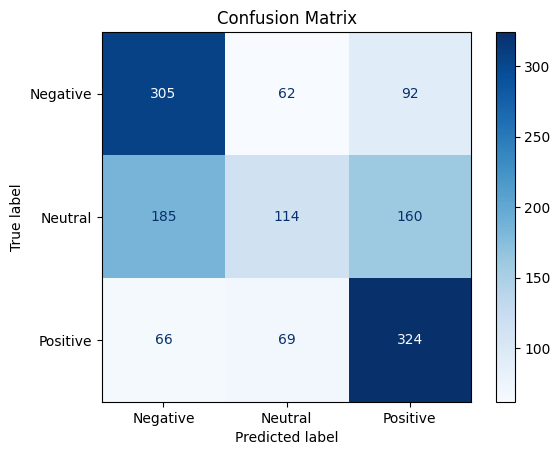

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.66      0.60       459
     Neutral       0.47      0.25      0.32       459
    Positive       0.56      0.71      0.63       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.52      1377
weighted avg       0.53      0.54      0.52      1377



In [30]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(mr_tri_train_bow, mr_train_labels)

predictions = tri_lsvm.predict(mr_tri_test_bow)
mr_ls_tri_bow = test_statistics(predictions, mr_test_labels)

##### 4.4.3.2 TFIDF

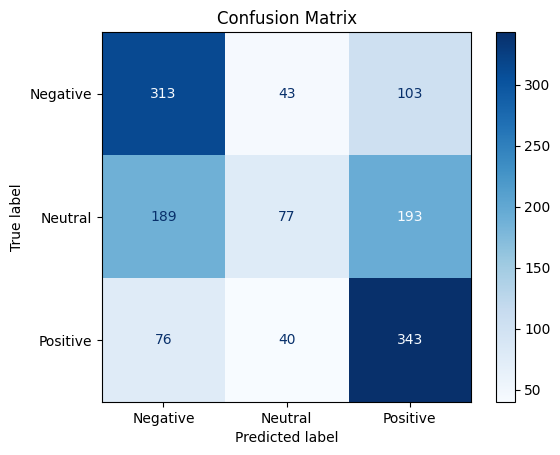

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.68      0.60       459
     Neutral       0.48      0.17      0.25       459
    Positive       0.54      0.75      0.62       459

    accuracy                           0.53      1377
   macro avg       0.52      0.53      0.49      1377
weighted avg       0.52      0.53      0.49      1377



In [31]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(mr_tri_train_tfidf, mr_train_labels)

predictions = tri_lsvm.predict(mr_tri_test_tfidf)
mr_ls_tri_tf = test_statistics(predictions, mr_test_labels)

## 5. Ergebnisse

In den Confusion Matritzen ist gut zu erkennen, dass die klassischen Algorithmen positive und negative Bewertungen tendenziell voneinander unterscheiden können.  
Große Probleme haben sie jedoch bei den neutralen Bewertungen. Diese werden von den Algorithmen häufiger als positive oder negative Bewertungen klassifiziert.  
Das Label "neutral" wird bei den tatsächlich neutralen Bewertungen am seltensten vergeben, der Recall Wert liegt mit 0.32 sogar unter dem Zufallswert. Da wir mit balancierten Daten arbeiten, liegt dieser bei 0.333
Der Naive Bayes Algorithmus auf Trigram TFIDF Daten schafft es immerhin "neutral" als zweithäufigstes Label bei tatsächlich neutralen Bewertungen zu erkennen.
Zudem ist es möglich durch den Parameter "class_prior" den Prior für neutrale Bewertungen hochzusetzen und gleichzeitig den Prior für positive und negative Bewertungen herunterzusetzen. Dadurch können die neutralen Reviews deutlich besser erkannt werden. Da gleichzeitig die positiven und negativen Reviews entsprechend schlechter erkannt werden, verbessert sich die Accuracy nicht sondern wird sogar leicht schlechter.
Damit kommen wir nach umfangreichen testen zu dem Ergebnis, dass die klassischen Klassifizierungsalgorithmen einen guten Beitrag zur Unterscheidung zwischen positiven und negativen Sentiments leisten.
Sie funktioneren jedoch auf unseren Daten nicht mehr so gut, wenn eine dritte (neutrale) Klasse vorliegt.

Der Multinomial Naive Bayes Algorithmus erzielt auf unserem Movie-Review Datensatz die besten Ergebnisse.  
Trotz der verletzten Annahme "Unabhängigkeit zwischen den einzelnen Features", funktioniert dieser Algorithmus von den klassischen Modellen am besten.  

Zwischen den BoW und TFIDF Features gibt es dabei nur geringe Unterschiede in der Accuracy.
TFIDF Features liefern insbesondere bei den Unigrams eine leicht bessere Accuracy, da sie mit dem IDF-Score mehr Informatoinen enthalten als die BoW Features. Der Unterschied ist allerdings nur sehr gering.

Überraschend hingegen ist die Erkenntnis, dass Features aus Bi- und Trigrams schlechtere Ergebnisse liefern als Features aus Unigrams, obwohl sie mehr Informationen enthalten.  
Kommentare wie z.B. "nicht gut" können bei den Features aus Bi- und Trigramms ebenfalls erfasst werden, bei den Features aus Unigrams würden "nicht" und "gut" einzeln gezählt werden und nicht mehr im direkten Zusammenhang stehen. Möglicherweise können einzelne Wörter eher im Testset wiedergefunden werden als Wortpermutationen. 

### 5.1. Bag-of-Words Ergebnisse

In [32]:
mr_bow = {'Naive Bayes': [mr_nb_uni_bow, mr_nb_bi_bow, mr_nb_tri_bow], 'Log Regression': [mr_lr_uni_bow, mr_lr_bi_bow, mr_lr_tri_bow], 'LSVM': [mr_ls_uni_bow, mr_ls_bi_bow, mr_ls_tri_bow]}
df_mr_bow = pd.DataFrame((mr_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_bow)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.551198        0.546841  0.527959
Bi-gram      0.540305        0.538126  0.533043
Tri-gram     0.536674        0.533043  0.539579


### 5.2. TFIDF Ergebnisse

In [33]:
(mr_tfidf) = {'Naive Bayes': [mr_nb_uni_tf, mr_nb_bi_tf, mr_nb_tri_tf], 'Log Regression': [mr_lr_uni_tf, mr_lr_bi_tf, mr_lr_tri_tf], 'LSVM': [mr_ls_uni_tf, mr_ls_bi_tf, mr_ls_tri_tf]}
df_mr_tfidf = pd.DataFrame((mr_tfidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_tfidf)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.561365        0.557734  0.545389
Bi-gram      0.538853        0.530864  0.536674
Tri-gram     0.539579        0.525781  0.532317


## Tweets (größeres Daten-Set)
- 1,6 mio Samples (nach Balancing)
- 2 Klassen: -1: negativ, 1: positiv
  
Da dieser Datensatz deutlich größer ist, spielt hier auch die Trainingsdauer eine Rolle. 
Daher haben wir hier nicht nur die Vorhersagequalität sondern auch die benötigte Zeit für das Training der Modelle miteinander verglichen. 
Ansonsten haben wir hier den gleichen Code angewandt, wie bei dem kleineren Datensatz, daher ist unser Vorgehen nicht noch einmal beschrieben.  


## 1. Data Loading

In [34]:
tw_train_set = pd.read_csv ("data/dataset_tw/Trainset_complete.csv", sep = ';')
tw_test_set = pd.read_csv ("data/dataset_tw/Testset.csv", sep = ';')

In [35]:
# Daten um NaNs bereinigen
tw_train_set = tw_train_set.dropna()

# Sicherstellen, dass in "Phrase" nur strings stehen, damit Daten weiterverarbeitet werden können
tw_train_set ['Phrase'] = tw_train_set['Phrase'].astype(str)

## 2. Data Cleaning

In [36]:
# Für Sentimentanalyse zählen nur Wörter
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text

# Groß- und Kleinschreibung egal
def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


tw_train_set['Phrase'] = tw_train_set['Phrase'].apply(clean_reviews)
tw_test_set['Phrase'] = tw_test_set['Phrase'].apply(clean_reviews)

#tw_train_set['Phrase'] = tw_train_set['Phrase'].apply(remove_stop_words)
#tw_test_set['Phrase'] = tw_test_set['Phrase'].apply(remove_stop_words)

tw_train_set['Phrase'] = tw_train_set['Phrase'].apply(text_stemming)
tw_test_set['Phrase'] = tw_test_set['Phrase'].apply(text_stemming)

## 3. Text Vectorization

In [37]:
# Vectorizer für Bag-of-Words
# Unigram
tw_vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
tw_vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
tw_vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))


In [38]:
# Vectorizer für TFIDF
# Unigram
tw_vectorizer_uni_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
tw_vectorizer_bi_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
tw_vectorizer_tri_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [39]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - BoW

tw_uni_train_bow = tw_vectorizer_uni_bow.fit_transform(tw_train_set['Phrase'])
tw_uni_test_bow = tw_vectorizer_uni_bow.transform(tw_test_set['Phrase'])

tw_bi_train_bow = tw_vectorizer_bi_bow.fit_transform(tw_train_set['Phrase'])
tw_bi_test_bow = tw_vectorizer_bi_bow.transform(tw_test_set['Phrase'])

tw_tri_train_bow = tw_vectorizer_tri_bow.fit_transform(tw_train_set['Phrase'])
tw_tri_test_bow = tw_vectorizer_tri_bow.transform(tw_test_set['Phrase'])

In [40]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TFIDF

tw_uni_train_tfidf = tw_vectorizer_uni_tfidf.fit_transform(tw_train_set['Phrase'])
tw_uni_test_tfidf = tw_vectorizer_uni_tfidf.transform(tw_test_set['Phrase'])

tw_bi_train_tfidf = tw_vectorizer_bi_tfidf.fit_transform(tw_train_set['Phrase'])
tw_bi_test_tfidf= tw_vectorizer_bi_tfidf.transform(tw_test_set['Phrase'])

tw_tri_train_tfidf = tw_vectorizer_tri_tfidf.fit_transform(tw_train_set['Phrase'])
tw_tri_test_tfidf = tw_vectorizer_tri_tfidf.transform(tw_test_set['Phrase'])


In [41]:
tw_train_labels = tw_train_set['Sentiment']
tw_test_labels = tw_test_set['Sentiment']
tw_train_labels = tw_train_labels.astype(int)
tw_test_labels = tw_test_labels.astype(int)

## 4. Klassifikationsmodelle trainieren

### 4.1.  Naive Bayes

#### 4.1.1. Naive Bayes: Unigram

##### 4.1.1.1 Bag-of-Words

train time: 1.25s


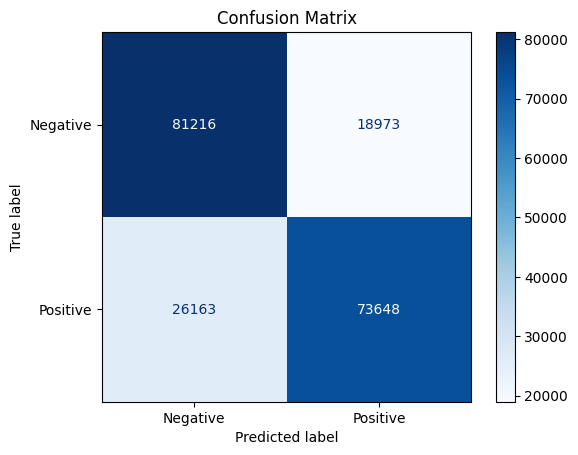

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78    100189
    Positive       0.80      0.74      0.77     99811

    accuracy                           0.77    200000
   macro avg       0.78      0.77      0.77    200000
weighted avg       0.78      0.77      0.77    200000



In [50]:
uni_nb = MultinomialNB()
t0 = time()

uni_nb.fit(tw_uni_train_bow, tw_train_labels)

tt_nb_uni_bow = time() - t0
print(f"train time: {tt_nb_uni_bow:.3}s")

predictions = uni_nb.predict(tw_uni_test_bow)

tw_nb_uni_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.1.1.2 TFIDF

train time: 1.25s


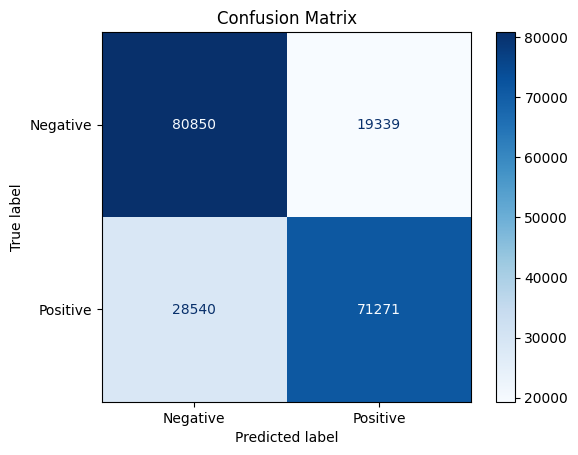

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.74      0.81      0.77    100189
    Positive       0.79      0.71      0.75     99811

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



In [51]:
uni_nb = MultinomialNB()
t0 = time()

uni_nb.fit(tw_uni_train_tfidf, tw_train_labels)

tt_nb_uni_tf = time() - t0
print(f"train time: {tt_nb_uni_tf:.3}s")

predictions = uni_nb.predict(tw_uni_test_tfidf)

tw_nb_uni_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.1.2. Naive Bayes: Bigram

##### 4.1.2.1 Bag-of-Words

train time: 3.67s


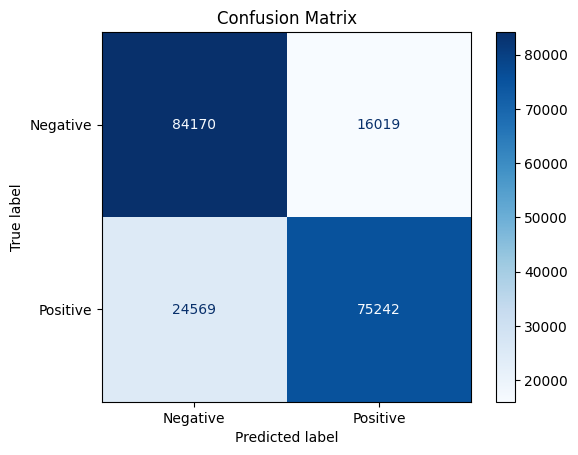

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.84      0.81    100189
    Positive       0.82      0.75      0.79     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [52]:
bi_nb = MultinomialNB()
t0 = time()

bi_nb.fit(tw_bi_train_bow, tw_train_labels)

tt_nb_bi_bow = time() - t0
print(f"train time: {tt_nb_bi_bow:.3}s")

predictions = bi_nb.predict(tw_bi_test_bow)
tw_nb_bi_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])


##### 4.1.2.2 TFIDF

train time: 3.52s


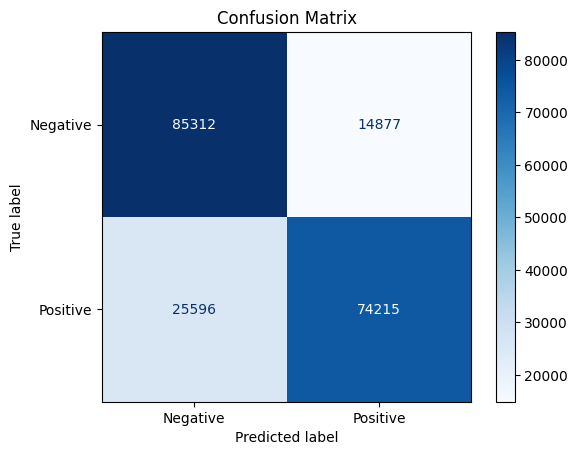

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.85      0.81    100189
    Positive       0.83      0.74      0.79     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [53]:
bi_nb = MultinomialNB()
t0 = time()

bi_nb.fit(tw_bi_train_tfidf, tw_train_labels)

tt_nb_bi_tf = time() - t0
print(f"train time: {tt_nb_bi_tf:.3}s")

predictions = bi_nb.predict(tw_bi_test_tfidf)
tw_nb_bi_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.1.3. Naive Bayes: Trigram

##### 4.1.3.1 Bag-of-Words

train time: 5.47s


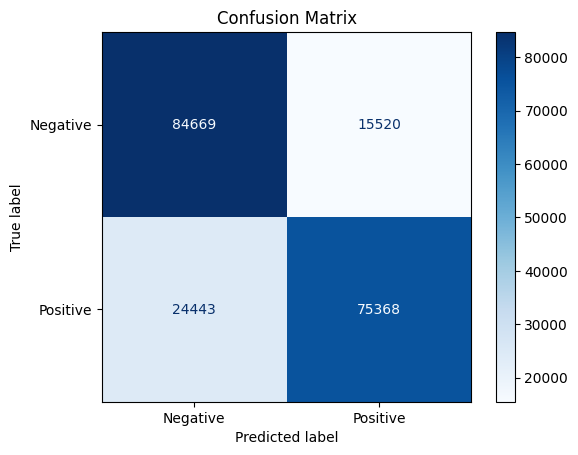

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.78      0.85      0.81    100189
    Positive       0.83      0.76      0.79     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [54]:
tri_nb = MultinomialNB()
t0 = time()

tri_nb.fit(tw_tri_train_bow, tw_train_labels)

tt_nb_tri_bow = time() - t0
print(f"train time: {tt_nb_tri_bow:.3}s")

predictions = tri_nb.predict(tw_tri_test_bow)
tw_nb_tri_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])


##### 4.1.3.2 TFIDF

train time: 3.766s


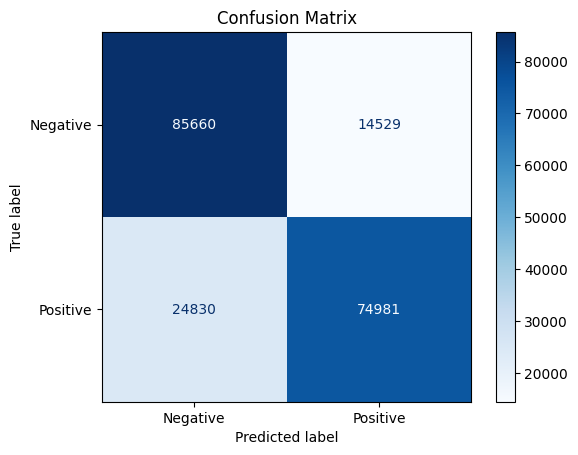

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.78      0.85      0.81    100189
    Positive       0.84      0.75      0.79     99811

    accuracy                           0.80    200000
   macro avg       0.81      0.80      0.80    200000
weighted avg       0.81      0.80      0.80    200000



In [58]:
tri_nb = MultinomialNB()
t0 = time()

tri_nb.fit(tw_tri_train_tfidf, tw_train_labels)

tt_nb_tri_tf = time() - t0
print(f"train time: {tt_nb_tri_tf:.3f}s")

predictions = tri_nb.predict(tw_tri_test_tfidf)
tw_nb_tri_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

### 4.2 Logistische Regression

#### 4.2.1. Log Regression: Unigram

##### 4.2.1.1 Bag-of-Words

In [59]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

uni_logreg.fit(tw_uni_train_bow, tw_train_labels)

tt_lr_uni_bow = time() - t0
print(f"train time: {tt_lr_uni_bow:.3f}s")

predictions = uni_logreg.predict(tw_uni_test_bow)
tw_lr_uni_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.1.2 TFIDF

In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

uni_logreg.fit(tw_uni_train_tfidf, tw_train_labels)

tt_lr_uni_tf = time() - t0
print(f"train time: {tt_lr_uni_tf:.3f}s")

predictions = uni_logreg.predict(tw_uni_test_tfidf)
tw_lr_uni_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

KeyboardInterrupt: 

#### 4.2.2. Log Regression: Bigram

##### 4.2.2.1 Bag-of-Words

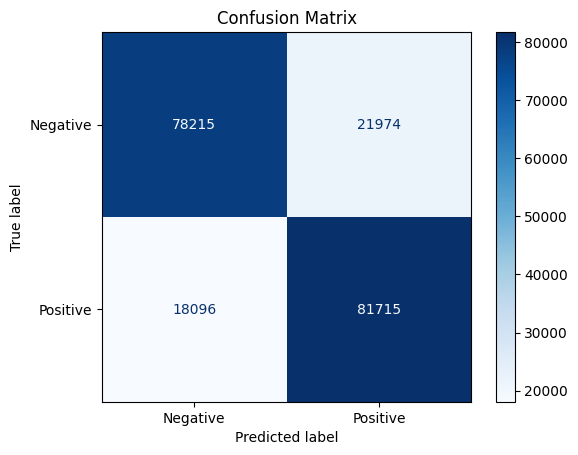

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80    100189
    Positive       0.79      0.82      0.80     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

bi_logreg.fit(tw_bi_train_bow, tw_train_labels)

tt_lr_bi_bow = time() - t0
print(f"train time: {tt_lr_bi_bow:.3f}s")

predictions = bi_logreg.predict(tw_bi_test_bow)
tw_lr_bi_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.2.2 TFIDF

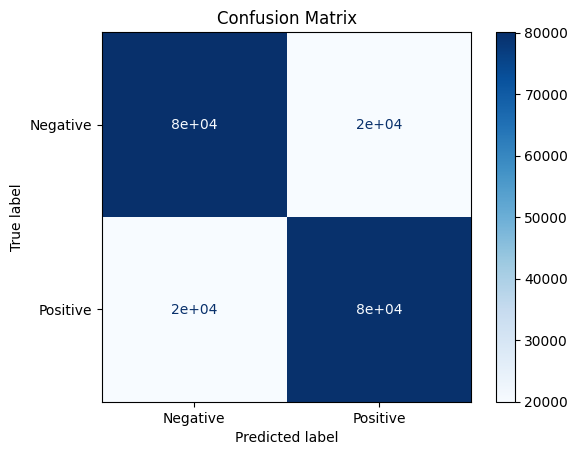

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80    100189
    Positive       0.80      0.80      0.80     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

bi_logreg.fit(tw_bi_train_tfidf, tw_train_labels)

tt_lr_bi_tf = time() - t0
print(f"train time: {tt_lr_bi_tf:.3f}s")

predictions = bi_logreg.predict(tw_bi_test_tfidf)
tw_lr_bi_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.2.3. Log Regression: Trigram

##### 4.2.3.1 Bag-of-Words

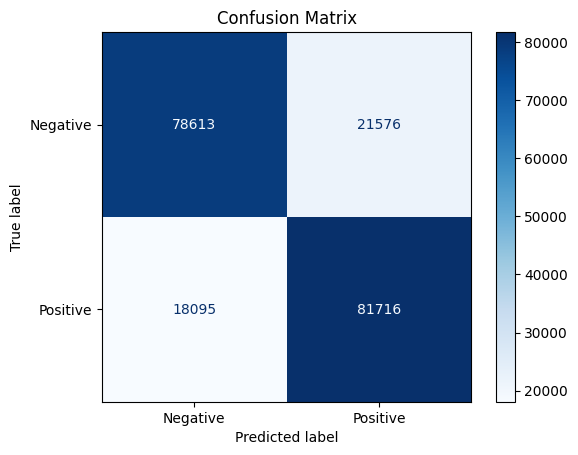

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80    100189
    Positive       0.79      0.82      0.80     99811

    accuracy                           0.80    200000
   macro avg       0.80      0.80      0.80    200000
weighted avg       0.80      0.80      0.80    200000



In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

tri_logreg.fit(tw_tri_train_bow, tw_train_labels)

tt_lr_tri_bow = time() - t0
print(f"train time: {tt_lr_tri_bow:.3f}s")

predictions = tri_logreg.predict(tw_tri_test_bow)
tw_lr_tri_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.2.3.2 TFIDF

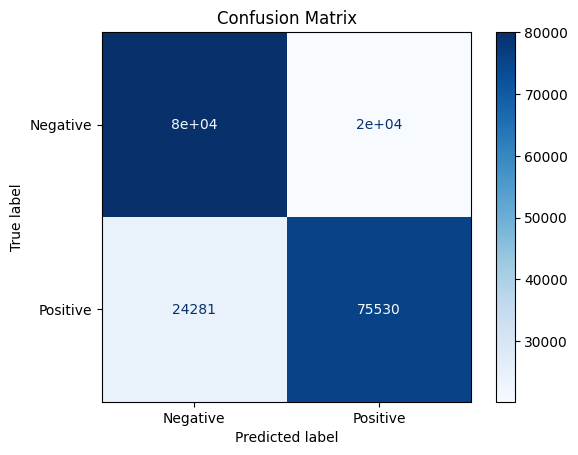

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.80      0.78    100189
    Positive       0.79      0.76      0.77     99811

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
t0 = time()

tri_logreg.fit(tw_tri_train_tfidf, tw_train_labels)

tt_lr_tri_tf = time() - t0
print(f"train time: {tt_lr_tri_tf:.3f}s")

predictions = tri_logreg.predict(tw_tri_test_tfidf)
tw_lr_tri_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

### 4.3 Linear Support Vector Machine (LSVM)

#### 4.3.1. LSVM: Unigram

##### 4.3.1.1 Bag-of-Words

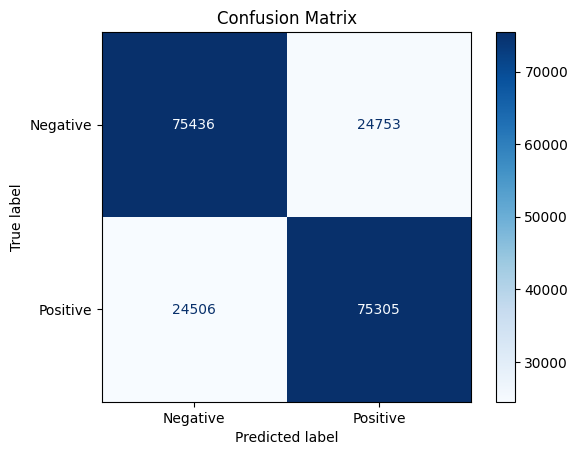

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75    100189
    Positive       0.75      0.75      0.75     99811

    accuracy                           0.75    200000
   macro avg       0.75      0.75      0.75    200000
weighted avg       0.75      0.75      0.75    200000



In [ ]:
uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

uni_lsvm.fit(tw_uni_train_bow, tw_train_labels)

tt_ls_uni_bow = time() - t0
print(f"train time: {tt_ls_uni_bow:.3f}s")

predictions = uni_lsvm.predict(tw_uni_test_bow)
tw_ls_uni_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.1.2 TFIDF

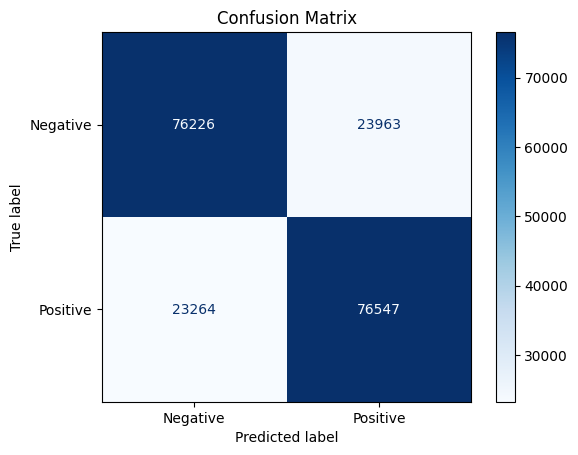

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.76      0.76    100189
    Positive       0.76      0.77      0.76     99811

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



In [ ]:
uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

uni_lsvm.fit(tw_uni_train_tfidf, tw_train_labels)

tt_ls_uni_tf = time() - t0
print(f"train time: {tt_ls_uni_tf:.3f}s")

predictions = uni_lsvm.predict(tw_uni_test_tfidf)
tw_ls_uni_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.3.2. LSVM: Bigram

##### 4.3.2.1 Bag-of-Words

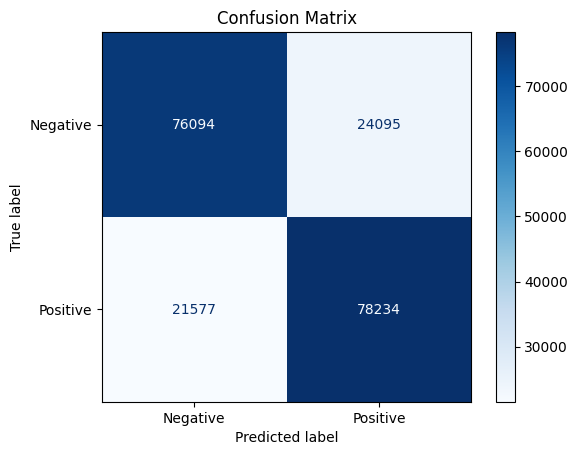

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77    100189
    Positive       0.76      0.78      0.77     99811

    accuracy                           0.77    200000
   macro avg       0.77      0.77      0.77    200000
weighted avg       0.77      0.77      0.77    200000



In [ ]:
bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

bi_lsvm.fit(tw_bi_train_bow, tw_train_labels)

tt_ls_bi_bow = time() - t0
print(f"train time: {tt_ls_bi_bow:.3f}s")

predictions = bi_lsvm.predict(tw_bi_test_bow)
tw_ls_bi_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.2.2 TFIDF

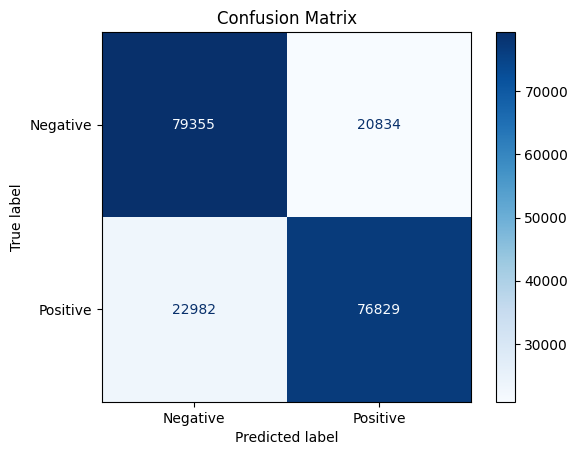

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    100189
    Positive       0.79      0.77      0.78     99811

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [ ]:
bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

bi_lsvm.fit(tw_bi_train_tfidf, tw_train_labels)

tt_ls_bi_tf = time() - t0
print(f"train time: {tt_ls_bi_tf:.3f}s")

predictions = bi_lsvm.predict(tw_bi_test_tfidf)
tw_ls_bi_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

#### 4.3.3. LSVM: Trigram

##### 4.3.3.1 Bag-of-Words

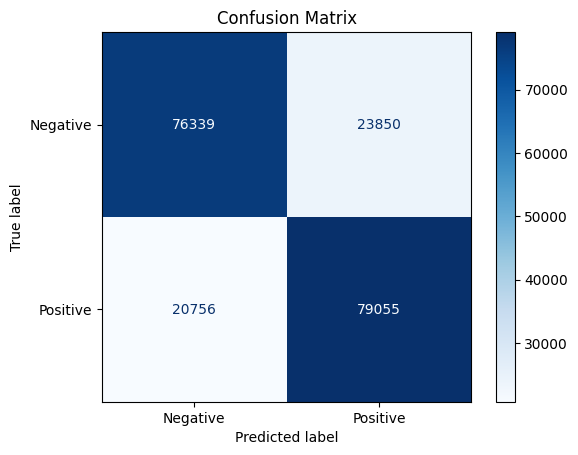

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.77    100189
    Positive       0.77      0.79      0.78     99811

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [ ]:
tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

tri_lsvm.fit(tw_tri_train_bow, tw_train_labels)

tt_ls_tri_bow = time() - t0
print(f"train time: {tt_ls_tri_bow:.3f}s")

predictions = tri_lsvm.predict(tw_tri_test_bow)
tw_ls_tri_bow = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

##### 4.3.3.2 TFIDF

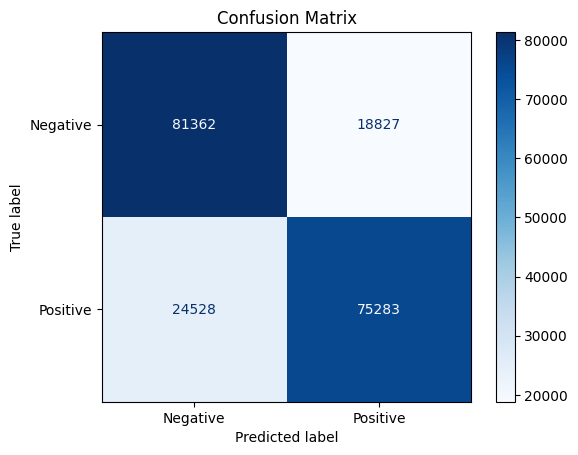

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.77      0.81      0.79    100189
    Positive       0.80      0.75      0.78     99811

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [ ]:
tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
t0 = time()

tri_lsvm.fit(tw_tri_train_tfidf, tw_train_labels)

tt_ls_tri_tf = time() - t0
print(f"train time: {tt_ls_tri_tf:.3f}s")

predictions = tri_lsvm.predict(tw_tri_test_tfidf)
tw_ls_tri_tf = test_statistics(predictions, tw_test_labels, target_labels=["Negative", "Positive"], target_indices=[-1,1])

## 5. Ergebnisse

### 5.1. Bag-of-Words Ergebnisse

In [ ]:
tw_bow = {'Naive Bayes': [tw_nb_uni_bow, tw_nb_bi_bow, tw_nb_tri_bow], 'Log Regression': [tw_lr_uni_bow, tw_lr_bi_bow, tw_lr_tri_bow], 'LSVM': [tw_ls_uni_bow, tw_ls_bi_bow, tw_ls_tri_bow]}
df_tw_bow = pd.DataFrame((tw_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])

tt_bow = {'Naive Bayes': [tt_nb_uni_bow, tt_nb_bi_bow, tt_nb_tri_bow], 'Log Regression': [tt_lr_uni_bow, tt_lr_bi_bow, tt_lr_tri_bow], 'LSVM': [tt_ls_uni_bow, tt_ls_bi_bow, tt_ls_tri_bow]}
df_tt_bow = pd.DataFrame((tt_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])

print(df_tw_bow)
print()
print("benötigte Zeit: ")
print(df_tt_bow)

NameError: name 'tw_nb_uni_bow' is not defined

### 5.2. TFIDF Ergebnisse

In [ ]:
(tw_tfidf) = {'Naive Bayes': [tw_nb_uni_tf, tw_nb_bi_tf, tw_nb_tri_tf], 'Log Regression': [tw_lr_uni_tf, tw_lr_bi_tf, tw_lr_tri_tf], 'LSVM': [tw_ls_uni_tf, tw_ls_bi_tf, tw_ls_tri_tf]}
df_tw_tfidf = pd.DataFrame((tw_tfidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])

(tt_tfidf) = {'Naive Bayes': [tt_nb_uni_tf, tt_nb_bi_tf, tt_nb_tri_tf], 'Log Regression': [tt_lr_uni_tf, tt_lr_bi_tf, tt_lr_tri_tf], 'LSVM': [tt_ls_uni_tf, tt_ls_bi_tf, tt_ls_tri_tf]}
df_tt_tfidf = pd.DataFrame((tt_tfidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])

print(df_tw_tfidf)
print()
print("benötigte Zeit: ")
print(df_tt_tfidf)

## 6. Übertragbarkeit der Modelle

Im abschließenden Schritt möchten wir die Übertragbarkeit unserer trainierten Modelle testen. Dafür testen wir wie gut ein Modell, das auf dem Movie-Review Datensatz trainiert wurde, auf den Tweets-Testset performt und anders herum. Dafür nehmen wir das jeweils beste Modell der Datensätze.
- Movie-Revies: Naive Bayes auf Unigram TFIDF Features
- Tweets: 

Das auf den Movie-Review Daten trainierte und mit Tweets Daten getestete Naive Bayes Modell auf Unigram TFIDF Features erreicht immerhin eine Accuracy von 0.40. Da es auf den Movie Daten trainiert wurde, sind neutrale Vorhersagen ebenfalls möglich, auch wenn es diese im Tweets Datensatz nicht gibt. 
Der Precision Wert liegt für positive sowie negative Reviews bei 0.61, was bedeutet, dass 61% der positiv vorhergrsagten Samples tatsächlich positiv waren. 39% der vom Modell als positiv klassifizierten Samples waren eigentlich negative Tweets. 
Somit liegt sowohl die Accuracy, als auch die Precision über dem Zufallswert.  
Wir können also davon ausgehen, dass einige Wörter bzw. Wortpermutationen nicht Movie-Review spezifisch sind, sondern auch auf andere Aufgaben im Rahmen der Sentimen-Analyse übertragbar sind. Allerdings funktioniert die Trennung zwischen positiven und negativen Klassen nicht mehr so gut wie bei dem Modell, das auf Tweets Daten trainiert und auch getestet wurde   

Das auf den Tweets Daten trainierte und mit Movie-Review Daten getestete xy Modell auf xy Features erreicht eine Accuracy von 0.44  
Da es keine neutralen Klassen im Tweets Datensatz gibt, kann dieses Modell nur die Klassen positiv und negativ voraussagen.  
Da von den insgesamt 1377 Samples im Test Datensatz 459 der neutralen Klasse angehören, ist die bestmögliche Accuracy auf 0.66 eingeschränkt.   
Auch hier scheint es also Wörter bzw. Wort-Permutationen zu geben, die sich auf andere Aufgaben im Themengebiet der Sentiment-Analyse übertragen lassen. 

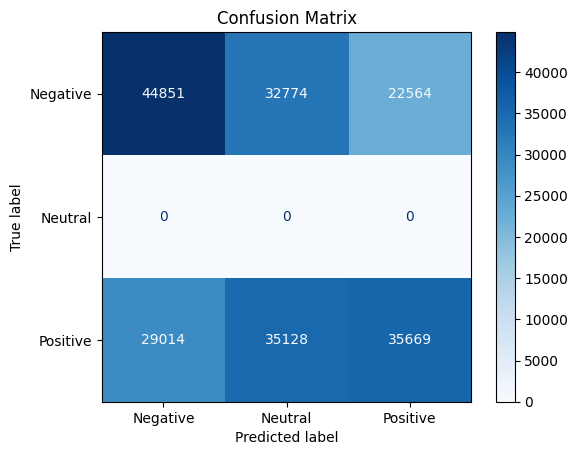

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.61      0.45      0.52    100189
     Neutral       0.00      0.00      0.00         0
    Positive       0.61      0.36      0.45     99811

    accuracy                           0.40    200000
   macro avg       0.41      0.27      0.32    200000
weighted avg       0.61      0.40      0.48    200000



In [ ]:
# Naive Bayes trainiert auf Unigram TFIDF Movie-Reviews, getestet auf Tweets Datensatz mit TFIDF Unigram Features
uni_nb = MultinomialNB()
#uni_nb.fit(mr_uni_train_tfidf, mr_train_labels)
uni_nb.fit(mr_uni_train_tfidf, mr_train_labels)

tw_uni_test_tfidf_vgl = mr_vectorizer_uni_tfidf.transform(tw_test_set['Phrase'])
predictions = uni_nb.predict(tw_uni_test_tfidf_vgl)

mr_nb_uni_tf = test_statistics(predictions, tw_test_labels)

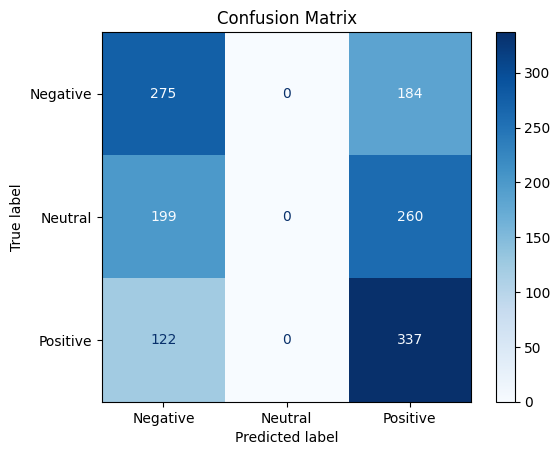

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.46      0.60      0.52       459
     Neutral       0.00      0.00      0.00       459
    Positive       0.43      0.73      0.54       459

    accuracy                           0.44      1377
   macro avg       0.30      0.44      0.35      1377
weighted avg       0.30      0.44      0.35      1377



In [ ]:
# bestes Tweets Modell, getestet mit Movie-Review Testset mit TFIDF Trigram Features
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tw_tri_train_tfidf, tw_train_labels)

mr_tri_test_tfidf_vgl = tw_vectorizer_tri_tfidf.transform(mr_test_set['Phrase'])
predictions = tri_logreg.predict(mr_tri_test_tfidf_vgl)
tw_lr_tri_tf = test_statistics(predictions, mr_test_labels, target_labels=["Negative", "Neutral", "Positive"], target_indices=[-1,0,1])

Quellen:  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html  
https://scikit-learn.org/stable/modules/naive_bayes.html  
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
https://dropsofai.com/sentiment-analysis-with-python-bag-of-words/  
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py  

